In [ ]:
!pip install kaggle 

In [ ]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
import pandas as pd
from fastai.tabular.all import *

## Extract Data

In [ ]:
path = URLs.path('ethereum')
path

In [ ]:
#hide
Path.BASE_PATH = path

In [ ]:
file_extract(path/'archive.zip')

path.ls(file_type='text')

In [381]:
df = pd.read_csv(path/'Ethereum Historical Data.csv', low_memory=False)

In [382]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,"May 30, 2021","2,380.70","2,276.97","2,465.84","2,181.93",3.16M,4.60%
1,"May 29, 2021","2,276.07","2,411.68","2,567.42","2,207.21",2.94M,-5.73%
2,"May 28, 2021","2,414.29","2,742.39","2,760.17","2,332.43",3.26M,-11.75%
3,"May 27, 2021","2,735.88","2,885.02","2,885.87","2,638.62",2.39M,-5.16%
4,"May 26, 2021","2,884.66","2,705.69","2,908.37","2,648.10",2.66M,6.64%
...,...,...,...,...,...,...,...
1903,"Mar 14, 2016",12.5,15.07,15.07,11.4,92.18K,-17.05%
1904,"Mar 13, 2016",15.07,12.92,15.07,12.92,1.30K,16.64%
1905,"Mar 12, 2016",12.92,11.95,13.45,11.95,0.83K,8.12%
1906,"Mar 11, 2016",11.95,11.75,11.95,11.75,0.18K,1.70%


### Prepare Data

In [383]:
df['Price'] = df['Price'].str.replace(',', '').astype(float)

In [384]:
df['High'] = df['High'].str.replace(',', '').astype(float)

In [385]:
df['Low'] = df['Low'].str.replace(',', '').astype(float)

In [386]:
df['Open'] = df['Open'].str.replace(',', '').astype(float)

In [387]:
def value_to_float(x):
    if type(x) == float or type(x) == int:
        return x
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) * 1000
        return 1000.0
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 1000000
        return 1000000.0
    if 'B' in x:
        return float(x.replace('B', '')) * 1000000000
    return 0.0

In [388]:
df['Vol.'] = df['Vol.'].apply(value_to_float)

In [389]:
df['Change %'] = df['Change %'].str.rstrip('%').astype('float') / 100.0

In [390]:
df = add_datepart(df, 'Date')

In [391]:
df

,Price,Open,Week,High,Low,Vol.,Change %,Year,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,2380.70,2276.97,21,2465.84,2181.93,3160000.0,0.0460,2021,5,30,6,150,False,False,False,False,False,False,1622332800
1,2276.07,2411.68,21,2567.42,2207.21,2940000.0,-0.0573,2021,5,29,5,149,False,False,False,False,False,False,1622246400
2,2414.29,2742.39,21,2760.17,2332.43,3260000.0,-0.1175,2021,5,28,4,148,False,False,False,False,False,False,1622160000
3,2735.88,2885.02,21,2885.87,2638.62,2390000.0,-0.0516,2021,5,27,3,147,False,False,False,False,False,False,1622073600
4,2884.66,2705.69,21,2908.37,2648.10,2660000.0,0.0664,2021,5,26,2,146,False,False,False,False,False,False,1621987200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1903,12.50,15.07,11,15.07,11.40,92180.0,-0.1705,2016,3,14,0,74,False,False,False,False,False,False,1457913600
1904,15.07,12.92,10,15.07,12.92,1300.0,0.1664,2016,3,13,6,73,False,False,False,False,False,False,1457827200
1905,12.92,11.95,10,13.45,11.95,830.0,0.0812,2016,3,12,5,72,False,False,False,False,False,False,1457740800
1906,11.95,11.75,10,11.95,11.75,180.0,0.0170,2016,3,11,4,71,False,False,False,False,False,False,1457654400


### Dependent Variable

In [392]:
dep_var = 'Price'

In [393]:
df[dep_var] = np.log(df[dep_var])

### Define train and valid set

In [394]:
cond = (df.Year<2021)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))
df.loc[valid_idx]

,Price,Open,Week,High,Low,Vol.,Change %,Year,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,7.775150,2276.97,21,2465.84,2181.93,3160000.0,0.0460,2021,5,30,6,150,False,False,False,False,False,False,1622332800
1,7.730206,2411.68,21,2567.42,2207.21,2940000.0,-0.0573,2021,5,29,5,149,False,False,False,False,False,False,1622246400
2,7.789161,2742.39,21,2760.17,2332.43,3260000.0,-0.1175,2021,5,28,4,148,False,False,False,False,False,False,1622160000
3,7.914208,2885.02,21,2885.87,2638.62,2390000.0,-0.0516,2021,5,27,3,147,False,False,False,False,False,False,1622073600
4,7.967162,2705.69,21,2908.37,2648.10,2660000.0,0.0664,2021,5,26,2,146,False,False,False,False,False,False,1621987200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,7.002629,1042.48,1,1131.56,976.91,3250000.0,0.0548,2021,1,5,1,5,False,False,False,False,False,False,1609804800
146,6.949281,977.76,1,1158.27,894.24,5190000.0,0.0692,2021,1,4,0,4,False,False,False,False,False,False,1609718400
147,6.882407,774.54,53,1008.49,769.57,4020000.0,0.2588,2021,1,3,6,3,False,False,False,False,False,False,1609632000
148,6.652218,729.00,53,787.26,715.15,2250000.0,0.0622,2021,1,2,5,2,False,False,False,False,False,False,1609545600


### create categorical and continuous variables

In [395]:
cont_nn,cat_nn = cont_cat_split(df, max_card=9000, dep_var=dep_var)
cat_nn.remove('Year')
cont_nn.append('Year')
cont_nn,cat_nn

(['Open', 'High', 'Low', 'Vol.', 'Change %', 'Year'],
 ['Week',
  'Month',
  'Day',
  'Dayofweek',
  'Dayofyear',
  'Is_month_end',
  'Is_month_start',
  'Is_quarter_end',
  'Is_quarter_start',
  'Is_year_end',
  'Is_year_start',
  'Elapsed'])

In [428]:
procs_nn = [Categorify]
to_nn = TabularPandas(df, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)
dls = to_nn.dataloaders(32)
y = to_nn.train.y
y.min(),y.max()

(1.9021075, 7.229839)

In [429]:
dls.valid.loc[1:200]

,Price,Open,Week,High,Low,Vol.,Change %,Year,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
1,7.730206,2411.679932,21,2567.419922,2207.209961,2940000.0,-0.0573,2021,5,29,6,149,1,1,1,1,1,1,1907
2,7.789161,2742.389893,21,2760.169922,2332.429932,3260000.0,-0.1175,2021,5,28,5,148,1,1,1,1,1,1,1906
3,7.914208,2885.020020,21,2885.870117,2638.620117,2390000.0,-0.0516,2021,5,27,4,147,1,1,1,1,1,1,1905
4,7.967162,2705.689941,21,2908.370117,2648.100098,2660000.0,0.0664,2021,5,26,3,146,1,1,1,1,1,1,1904
5,7.902891,2647.270020,21,2747.489990,2388.810059,3280000.0,0.0220,2021,5,25,2,145,1,1,1,1,1,1,1903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,7.002629,1042.479980,1,1131.560059,976.909973,3250000.0,0.0548,2021,1,5,2,5,1,1,1,1,1,1,1763
146,6.949281,977.760010,1,1158.270020,894.239990,5190000.0,0.0692,2021,1,4,1,4,1,1,1,1,1,1,1762
147,6.882407,774.539978,53,1008.489990,769.570007,4020000.0,0.2588,2021,1,3,7,3,1,1,1,1,1,1,1761
148,6.652218,729.000000,53,787.260010,715.150024,2250000.0,0.0622,2021,1,2,6,2,1,1,1,1,1,1,1760


### Learn

metric

In [430]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)

find learning rate

SuggestedLRs(lr_min=0.0007585775572806596, lr_steep=0.0014454397605732083)

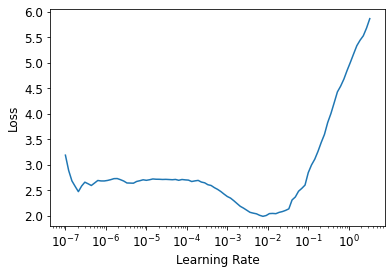

In [431]:
learn = tabular_learner(dls, y_range=(1,8), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)
learn.lr_find()

In [432]:
learn.fit_one_cycle(6, 1e-2)

epoch,train_loss,valid_loss,time
0,0.902993,0.291855,00:00
1,0.645826,0.232074,00:00
2,0.378007,0.016552,00:00
3,0.210147,0.049845,00:00
4,0.132752,0.020792,00:00
5,0.086876,0.011546,00:00


In [433]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.107454

In [434]:
learn.save('nn')

Path('models/nn.pth')

### example for prediction

In [435]:
learn.predict(dls.valid.loc[1])

(   Week  Month   Day  Dayofweek  Dayofyear  Is_month_end  Is_month_start  \
 0  21.0    5.0  29.0        7.0      149.0           2.0             2.0   
 
    Is_quarter_end  Is_quarter_start  Is_year_end  Is_year_start  Elapsed  \
 0             2.0               2.0          2.0            2.0      0.0   
 
           Open         High          Low       Vol.  Change %    Year  \
 0  2411.679932  2567.419922  2207.209961  2940000.0   -0.0573  2021.0   
 
       Price  
 0  7.806427  ,
 tensor([7.8064]),
 tensor([7.8064]))

In [438]:
data = {'Date':  ['July 16, 2021'],
       'Open':  ['2320.15'],
       'High':  ['2326.18'],
       'Low':  ['2141.94'],
       'Vol.':  ['3960000'],
       'Change %':  ['-0.038']}

df1 = pd.DataFrame(data)
df1 = add_datepart(df1, 'Date')
df1

,Open,High,Week,Low,Vol.,Change %,Year,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,2320.15,2326.18,28,2141.94,3960000,-0.038,2021,7,16,4,197,False,False,False,False,False,False,1626393600


In [439]:
d, price, b = learn.predict(df1.squeeze(axis=0))
np.exp(price)

tensor([2192.3943])